<a href="https://colab.research.google.com/github/fintechsteve/modeling-volatility/blob/master/Part_05_Creating_Turbulence_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 05: Creating a Turbulence Model

### In this section you will:


*   Create a turbulence function that estimates turbulence with a rolling window.
*   Transform a turbulence signal into set of dynamic weights. Track performance of the model.
*   Optimize the lookback and smoothing window.


## Import all necessary libraries

For this piece, we will need the following packages to be available to our environment:

*   Numpy and Pandas (For data manipulation)
*   DateTime (For basic date manipulation)
*   Matplotlib (For timeseries vizualization)

If the packages are not available, install the with "pip install X"

In [0]:
import numpy as np, pandas as pd
from datetime import datetime, timedelta
import pickle
import matplotlib.pyplot as plt

### Read in data from previously stored returns.pkl file



In [74]:
with open('./returns.pkl', 'rb') as f:
    returns = pickle.load(f)
    f.close()
returns.head(10)

,AUD,CAD,CHF,EUR,GBP,JPY,NOK,NZD,SEK
1975-01-02,-0.002129,-1.712061e-03,-0.009915,-0.003544,-0.005745,-0.001502,-0.003299,0.000536,-0.004704
1975-01-03,-0.000947,1.517425e-05,0.008500,0.007886,0.003424,0.002711,0.008801,-0.001924,0.007113
1975-01-06,-0.001158,6.677374e-04,-0.001023,0.008174,0.002346,-0.004728,0.002759,-0.001129,0.009237
1975-01-07,0.004193,-1.726304e-03,0.001702,0.002150,0.001702,0.002410,0.005434,0.004567,-0.001466
1975-01-08,-0.001489,-2.000930e-04,-0.015237,-0.008650,-0.001997,0.000122,-0.006315,-0.000034,-0.006188
1975-01-09,-0.000324,-3.120108e-03,0.000298,0.004764,0.000298,-0.000409,-0.000114,-0.001217,-0.000751
1975-01-10,0.000077,-1.283429e-03,0.001489,0.001489,0.001489,0.000075,0.006256,0.000311,0.001489
1975-01-13,0.000579,-3.152212e-07,0.001789,-0.001210,0.000127,-0.000578,0.000542,0.000969,-0.002488
1975-01-14,-0.000699,7.303998e-04,-0.005132,-0.006698,-0.001827,0.000291,-0.006558,-0.000762,-0.007795
1975-01-15,-0.000934,1.198868e-03,-0.002078,0.001797,-0.000426,-0.002542,-0.002276,-0.000594,0.000094


### Create a function that calculates turbulence for the whole window supplied using the last row as the observed return

Note that for faster computation we can replace ``` np.linalg.pinv(covmat)@(r - mu) ``` with ``` np.linalg.lstsq(covmat, r - mu)[0] ```

Also note that a more proper calculation of turbulence would only use rows 1:n-1 to calculate mean and covariance. But everybody seems to include n, so we aren't going to get upset here because it is simpler.

In [0]:
def simple_turbulence(rets):
  meanret = rets.mean()
  covrets = rets.cov()
  return pd.DataFrame((rets[-1:]-meanret)@np.linalg.lstsq(covrets,(rets[-1:]-meanret).T, rcond=None)[0],index=[rets.index[-1]],columns=['daily'])

In [36]:
simple_turbulence(returns)

,daily
2017-12-26,1.944164


### Create a function that calculates rolling turbulence given a lookback window and a smoothing window

To do this, we are going to create a function ```roll``` that generates a rolling window of returns for a specified window length, and a function that applies the turbulence calculation to that window.

In [0]:
def roll(df, w):
    for i in range(df.shape[0] - w + 1):
        yield pd.DataFrame(df.values[i:i+w, :], df.index[i:i+w], df.columns)
  
def rolling_turbulence(rets, lookback=260, smoothing=20):
    roll_turb = pd.concat([simple_turbulence(retwindow) for retwindow in roll(rets, lookback)], axis=0)
    roll_turb_smooth = pd.DataFrame(roll_turb.rolling(smoothing).mean()).rename(columns={'daily':'smoothed'})
    rets = rets.join(roll_turb)
    rets = rets.join(roll_turb_smooth)
    return rets[['daily','smoothed']]

In [72]:
roll_turb = rolling_turbulence(returns, lookback=260, smoothing=20)
roll_turb.tail(20)

,daily,smoothed
2017-11-29,11.708329,8.198902
2017-11-30,19.434739,8.275519
2017-12-01,16.035338,8.625853
2017-12-04,3.472929,8.539207
2017-12-05,4.495685,8.672033
2017-12-06,15.095148,9.194906
2017-12-07,6.858294,9.277124
2017-12-08,4.493710,9.385128
2017-12-11,15.851664,9.848611
2017-12-12,14.919482,9.333394


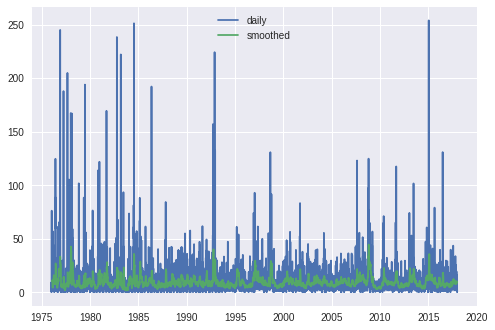

In [75]:
roll_turb.plot()

### Convert rolling turbulence into a weight (And do so in a function)



In [78]:
roll_turb['smoothed'].rank()/roll_turb['smoothed'].count()

1975-01-02         NaN
1975-01-03         NaN
1975-01-06         NaN
1975-01-07         NaN
1975-01-08         NaN
1975-01-09         NaN
1975-01-10         NaN
1975-01-13         NaN
1975-01-14         NaN
1975-01-15         NaN
1975-01-16         NaN
1975-01-17         NaN
1975-01-20         NaN
1975-01-21         NaN
1975-01-22         NaN
1975-01-23         NaN
1975-01-24         NaN
1975-01-27         NaN
1975-01-28         NaN
1975-01-29         NaN
1975-01-30         NaN
1975-01-31         NaN
1975-02-03         NaN
1975-02-04         NaN
1975-02-05         NaN
1975-02-06         NaN
1975-02-07         NaN
1975-02-10         NaN
1975-02-11         NaN
1975-02-12         NaN
                ...   
2017-11-15    0.672641
2017-11-16    0.579188
2017-11-17    0.576262
2017-11-20    0.582388
2017-11-21    0.570775
2017-11-22    0.496617
2017-11-23    0.472842
2017-11-24    0.439466
2017-11-27    0.446324
2017-11-28    0.455194
2017-11-29    0.479517
2017-11-30    0.486650
2017-12-01 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7d4283048>],
      dtype=object)

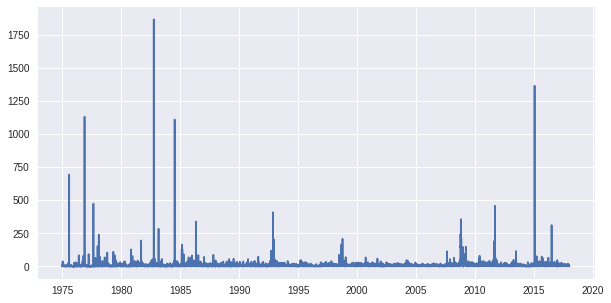

In [67]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
turbulence.plot(subplots=True, ax=axes, sharex=False, sharey=False, legend=False)

### Demonstrate that contemporaneously turbulence is concurrrent with high index volatility



In [0]:
dxy_weight = [0, 0.119, 0.036, 0, 0.136, 0.576, 0, 0, 0.091]
dxy = returns.dot(dxy_weight)

In [97]:
highturbulence = turbulence['daily']>np.percentile(turbulence['daily'],80)
pd.DataFrame([[np.sqrt(261)*dxy[highturbulence].std(), np.sqrt(261)*dxy[~highturbulence].std()], [sum(highturbulence), sum(~highturbulence)]], index=['std','N'], columns=['High Turb','Low Turb'])

,High Turb,Low Turb
std,0.122616,0.057833
N,2243.000000,8971.000000


### Demonstrate that turbulence leads to persistently high volatility days

In [123]:
leading_dxy = pd.DataFrame([dxy.shift(-i) for i in range(0, 11)]).T
subsequent_vol = pd.DataFrame([leading_dxy[highturbulence].std(), leading_dxy[~highturbulence].std()],index=['High Turb','Low Turb']).T
subsequent_vol

,High Turb,Low Turb
0,0.007590,0.003580
1,0.005493,0.004446
2,0.005453,0.004458
3,0.005319,0.004499
4,0.005441,0.004461
5,0.005424,0.004467
6,0.005321,0.004499
7,0.005109,0.004560
8,0.005221,0.004529
9,0.005095,0.004565


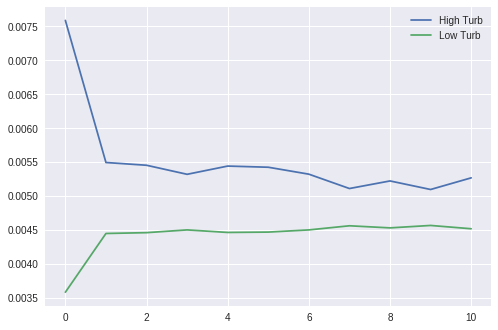

In [124]:
subsequent_vol.plot()